In [16]:
from requests import get
from requests.exceptions import Timeout, ConnectionError
from json import loads, load, dump
from re import sub
from os.path import exists
from os import makedirs, sep
from csv import reader, writer
import pandas as pd
from tqdm import tqdm
import logging
from urllib.parse import quote

headers = {
    "User-Agent": 
    "COVID-19 / OpenCitations "
    "(http://opencitations.net; mailto:contact@opencitations.net)"
}

# the base directory where to store the files with the full data
data_dir = "data"

# the CSV document containing the DOIs of the articles relevant for the analysis
doi_file = data_dir + sep + "dois.csv"

# the JSON document containing the citations of the articles relevant for the analysis
cit_file = data_dir + sep + "citations.json"

# the CSV document containing the DOIs of the articles relevant for the analysis that do not have references deposited in Crossref
doi_no_ref_file = data_dir + sep + "dois_no_ref.csv"

# the JSON document containing the metadata of the articles involved in the relevant citations
met_file = data_dir + sep + "metadata.json"

# the CSV document containing the DOIs of the articles for which Crossref does not return any information
nod_file = data_dir + sep + "metadata_not_found.csv"

In [40]:
# change the following variable to logging.INFO for removing debug, or logging.DEBUG to add debug messages
logging_level = logging.INFO

logging.basicConfig(format='%(levelname)s: %(message)s.')
log = logging.getLogger()
log.setLevel(logging_level)

In [51]:
opencitations_query = 'https://opencitations.net/index/api/v1/%s/%s?json=array("; ",citing).array("; ",cited).dict(" => ",citing,source,doi).dict(" => ",cited,source,doi)'   

def extract_citations(res, cit_id):
    result = list()
    res.encoding = "utf-8"
    for citation in loads(res.text):
        cit_id += 1
        citation_item = {
            "id": str(cit_id), 
            "source": citation["citing"][0]["doi"], 
            "target": citation["cited"][0]["doi"]
        }

        result.append(citation_item)
    
    return result, cit_id

def get_citations(cit_file, dois):
    citations = list()
    if not exists(cit_file):
        log.debug("The file with citations does not exist: start querying OpenCitations "
                      "for retrieving citation data")
        cit_id = 0
        for doi in tqdm(dois):
            logging.debug(f"Process DOI '{doi}'")
            reference_data = get(opencitations_query % ("references", doi), headers=headers)
            if reference_data.status_code == 200:
                all_citations, cit_id = extract_citations(reference_data, cit_id)
                for citation in all_citations:
                    if citation not in citations:
                        citations.append(citation)
            else:
                log.warning(f"Status code '{reference_data.status_code}' when requesting references for "
                                "DOI '{doi}'")
            citation_data = get(opencitations_query % ("citations", doi), headers=headers)
            if citation_data.status_code == 200:
                all_citations, cit_id = extract_citations(citation_data, cit_id)
                for citation in all_citations:
                    if citation not in citations:
                        citations.append(citation)
            else:
                log.warning(f"Status code '{citation_data.status_code}' when requesting citations for "
                                "DOI '{doi}'")

        with open(cit_file, "w") as f:
            dump(citations, f, ensure_ascii=False, indent=0)

    else:
        log.debug("The file with citations exist: load information directly from there.")
        with open(cit_file) as f:
            citations.extend(load(f))

    citing_dois = set()
    for citation in citations:
        citing_dois.add(citation["source"])

    articles_with_references = set()
    articles_without_references = set()
    for doi in dois:
        if doi in citing_dois:
            articles_with_references.add(doi)
        else:
            articles_without_references.add(doi)

    if not exists(doi_no_ref_file):
        with open(doi_no_ref_file, "w") as f:
            csv_writer = writer(f)
            for doi in articles_without_references:
                csv_writer.writerow((doi, ))

    log.info(f"Total citations available: {len(citations)}. Number of articles with references "
             f"deposited in Crossref and available in the OpenCitations Indexes: "
             f"{len(articles_with_references)} out of {len(dois)} total articles retrieved in Crossref")
    return citations

In [52]:
crossref_query = "https://api.crossref.org/works/"

def normalise(o):
    if o is None:
        s = ""
    else:
        s = str(o)
    return sub("\s+", " ", s).strip()

def create_title_from_list(title_list):
    cur_title = ""

    for title in title_list:
        strip_title = title.strip()
        if strip_title != "":
            if cur_title == "":
                cur_title = strip_title
            else:
                cur_title += " - " + strip_title

    return normalise(cur_title.title())

def get_basic_metadata(body):
    authors = []
    for author in body.get("author", []):
        authors.append(normalise(author.get("family", "").title()))

    year = ""
    if "issued" in body and "date-parts" in body["issued"] and len(body["issued"]["date-parts"]) and \
            len(body["issued"]["date-parts"][0]):
        year = normalise(body["issued"]["date-parts"][0][0])

    title = ""
    if "title" in body:
        title = create_title_from_list(body.get("title", []))

    source_title = ""
    if "container-title" in body:
        source_title = create_title_from_list(body.get("container-title", []))

    return ", ".join(authors), year, title, source_title

def get_metadata_for_citations(met_file, citations):
    dois_in_citations = set()
    for citation in citations:
        dois_in_citations.add(citation["source"])
        dois_in_citations.add(citation["target"])

    existing_doi = set()
    metadata = []
    if exists(met_file):
        with open(met_file) as f:
            for article in load(f):
                existing_doi.add(article["id"])
                metadata.append(article)

    if exists(nod_file):
        with open(nod_file) as f:
            csv_reader = reader(f)
            for doi, in csv_reader:
                existing_doi.add(doi)

    dois_not_found = []
    for doi in tqdm(dois_in_citations.difference(existing_doi)):
        log.debug(f"Requesting Crossref metadata for DOI '{doi}'")
        try:
            article = get(crossref_query + doi, headers=headers, timeout=20)
            if article.status_code == 200:
                article.encoding = "utf-8"
                article_json = loads(article.text).get("message")
                if article_json :
                    author, year, title, source_title = get_basic_metadata(article_json)
                    metadata.append({
                        "id": doi,
                        "author": author,
                        "year": year,
                        "title": title,
                        "source_title": source_title
                    })
                else:
                    log.warning(f"No article metadata in Crossref for DOI '{doi}'")
                    dois_not_found.append(doi)
            else:
                dois_not_found.append(doi)
                log.warning(f"Status code '{article.status_code}' when requesting Crossref metadata "
                            f"for DOI '{doi}'")
        except Timeout:
            dois_not_found.append(doi)
            log.warning(f"Timeout when querying Crossref for DOI '{doi}'")
        except ConnectionError:
            dois_not_found.append(doi)
            log.warning(f"Connection issues when querying Crossref for DOI '{doi}'")

    with open(met_file, "w") as f:
        dump(metadata, f, ensure_ascii=False, indent=0)

    if dois_not_found:
        with open(nod_file, "w") as f:
            csv_writer = writer(f)
            for doi in dois_not_found:
                csv_writer.writerow((doi, ))

    log.info(f"The total number of articles involved in the citations retrieved "
             f"are {len(metadata) + len(dois_not_found)}. "
             f"The total number of articles with available metadata is {len(metadata)}, "
             f"and there are {len(dois_not_found)} articles with no metadata found")
    return metadata

In [94]:
def get_citations_and_metadata(suffix, dois):
    cit_file = f'data/citations_{suffix}.csv'
    citations = get_citations(cit_file, dois)
    df_citations = pd.DataFrame(citations)
    
    metadata_file = f'data/metadata_{suffix}.csv'
    metadata = get_metadata_for_citations(metadata_file, citations)
    df_metadata = pd.DataFrame(metadata)
    
    df = df_citations.join(df_metadata.set_index(['id']).add_suffix('_source'), on='source')
    df = df.join(df_metadata.set_index(['id']).add_suffix('_target'), on='target')
    return df

In [65]:
dois = ['10.1029/92jb01206']

In [95]:
df_poi = get_citations_and_metadata('first_paper', dois)

INFO: Total citations available: 49. Number of articles with references deposited in Crossref and available in the OpenCitations Indexes: 1 out of 1 total articles retrieved in Crossref.

100%|██████████| 49/49 [00:45<00:00,  1.09it/s]
INFO: The total number of articles involved in the citations retrieved are 49. The total number of articles with available metadata is 49, and there are 0 articles with no metadata found.


## Get citations from papers citing the original paper

In [96]:
poi_citers = df_citations[lambda x: x['target'].isin(dois)]['source'].unique()

In [97]:
df_poi_citers = get_citations_and_metadata('poi_citers', poi_citers)

INFO: Total citations available: 1428. Number of articles with references deposited in Crossref and available in the OpenCitations Indexes: 22 out of 22 total articles retrieved in Crossref.

  0%|          | 0/2 [00:00<?, ?it/s]WARNING: Status code '404' when requesting Crossref metadata for DOI '10.1179/095066095790151197'.

100%|██████████| 2/2 [00:01<00:00,  1.20it/s]
INFO: The total number of articles involved in the citations retrieved are 1226. The total number of articles with available metadata is 1225, and there are 1 articles with no metadata found.


In [98]:
df_poi_citers.shape

(1428, 11)

In [102]:
def get_local_citation_data(poi_doi):
    df_poi = get_citations_and_metadata('first_paper', [poi_doi])
    
    poi_citers = df_citations[lambda x: x['target'].isin([poi_doi])]['source'].unique()
    df_poi_citers = get_citations_and_metadata('poi_citers', poi_citers)
    return pd.concat([df_poi, df_poi_citers])

In [109]:
df = get_local_citation_data(dois[0])

INFO: Total citations available: 49. Number of articles with references deposited in Crossref and available in the OpenCitations Indexes: 1 out of 1 total articles retrieved in Crossref.

  0%|          | 0/1 [00:00<?, ?it/s]WARNING: Status code '404' when requesting Crossref metadata for DOI '10.1179/095066083790411777'.

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
INFO: The total number of articles involved in the citations retrieved are 50. The total number of articles with available metadata is 49, and there are 1 articles with no metadata found.
INFO: Total citations available: 1428. Number of articles with references deposited in Crossref and available in the OpenCitations Indexes: 22 out of 22 total articles retrieved in Crossref.

  0%|          | 0/1 [00:00<?, ?it/s]WARNING: Status code '404' when requesting Crossref metadata for DOI '10.1179/095066095790151197'.

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
INFO: The total number of articles involved in the citations retri

In [110]:
df.shape

(1477, 11)

In [111]:
df.head()

,id,source,target,author_source,year_source,title_source,source_title_source,author_target,year_target,title_target,source_title_target
0,1,10.1029/92jb01206,10.1007/978-1-4613-9019-0_11,"Farver, Yund",1992,Oxygen Diffusion In A Fine-Grained Quartz Aggr...,Journal Of Geophysical Research,Joesten,1991,Grain-Boundary Diffusion Kinetics In Silicate ...,"Advances In Physical Geochemistry - Diffusion,..."
1,2,10.1029/92jb01206,10.1007/bf00310677,"Farver, Yund",1992,Oxygen Diffusion In A Fine-Grained Quartz Aggr...,Journal Of Geophysical Research,Watson,1991,Diffusion In Fluid-Bearing And Slightly-Melted...,Contributions To Mineralogy And Petrology
2,3,10.1029/92jb01206,10.1007/bf00373303,"Farver, Yund",1992,Oxygen Diffusion In A Fine-Grained Quartz Aggr...,Journal Of Geophysical Research,"Shieh, Taylor",1969,Oxygen And Hydrogen Isotope Studies Of Contact...,Contributions To Mineralogy And Petrology
3,4,10.1029/92jb01206,10.1016/0001-6160(75)90078-4,"Farver, Yund",1992,Oxygen Diffusion In A Fine-Grained Quartz Aggr...,Journal Of Geophysical Research,Beere,1975,A Unifying Theory Of The Stability Of Penetrat...,Acta Metallurgica
4,5,10.1029/92jb01206,10.1016/0009-2541(91)90033-n,"Farver, Yund",1992,Oxygen Diffusion In A Fine-Grained Quartz Aggr...,Journal Of Geophysical Research,"Farver, Yund",1991,Oxygen Diffusion In Quartz: Dependence On Temp...,Chemical Geology


In [112]:
df[['source', 'target']].duplicated().value_counts()

False    1445
True       32
dtype: int64

### Remark:
There can be two kinds of duplicates:
- all the citations between the poi_citers and the poi, we already got these in the poi-step
- citations between two poi_citers, for each of them the method will get the citation so they will appear twice

In [135]:
df.drop_duplicates(['source', 'target'], inplace=True)

In [136]:
df.shape

(1445, 11)

In [162]:
df['is_poi_ref'] = df['source'] == dois[0]
df['is_poi_citer'] = df['target'] == dois[0]

df['is_poi_citer_ref'] = df['source'].isin(poi_citers)
df['is_poi_citer_citer'] = df['target'].isin(poi_citers)

In [184]:
poi_citers

array(['10.1029/2008jb005884', '10.1002/2015jb012274',
       '10.1366/000370203321558173', '10.2465/jmps.071022a',
       '10.2465/minerj.19.147', '10.1007/s00269-013-0573-9',
       '10.1007/s00410-012-0822-9', '10.1007/s004100050019',
       '10.1007/s004100050020', '10.1029/94jb01250', '10.1029/94jb02816',
       '10.1007/978-94-011-1106-5_9', '10.1180/minmag.2009.073.5.825',
       '10.1111/jmg.12052', '10.1111/j.1525-1314.2010.00886.x',
       '10.1007/978-94-009-1533-6_9', '10.1002/2016gc006295',
       '10.1029/rf002p0269', '10.1007/bf00321221', '10.1029/95rg00601',
       '10.1029/97je03032', '10.1007/s00410-020-01676-2'], dtype=object)

In [185]:
test_dois = [dois[0], '10.1111/j.1525-1314.2010.00886.x']
print(test_dois)
df_test = df[lambda x: x['source'].isin(test_dois) | x['target'].isin(test_dois)]
df_test.shape

['10.1029/92jb01206', '10.1111/j.1525-1314.2010.00886.x']


(110, 18)

In [188]:
df_test[lambda x: x['source'].isin(poi_citers) & x['target'].isin(poi_citers)]

,id,source,target,author_source,year_source,title_source,source_title_source,author_target,year_target,title_target,source_title_target,is_poi_ref,is_poi_citer,is_poi_citer_ref,is_poi_citer_citer,is_poi_and_poi_citer_ref,is_poi_citer_and_poi_citer_citer,is_poi_and_poi_citer_citer
422,423,10.1111/j.1525-1314.2010.00886.x,10.1007/s004100050019,Carlson,2010,Dependence Of Reaction Kinetics On H2O Activit...,Journal Of Metamorphic Geology,"Farver, Yund",1995,"Grain Boundary Diffusion Of Oxygen, Potassium ...",Contributions To Mineralogy And Petrology,False,False,True,True,False,False,False
533,534,10.1111/j.1525-1314.2010.00886.x,10.1029/94jb01250,Carlson,2010,Dependence Of Reaction Kinetics On H2O Activit...,Journal Of Metamorphic Geology,"Farver, Yund, Rubie",1994,Magnesium Grain Boundary Diffusion In Forsteri...,Journal Of Geophysical Research: Solid Earth,False,False,True,True,False,False,False
779,780,10.1111/j.1525-1314.2010.00886.x,10.1007/bf00321221,Carlson,2010,Dependence Of Reaction Kinetics On H2O Activit...,Journal Of Metamorphic Geology,Brenan,1993,Diffusion Of Chlorine In Fluid-Bearing Quartzi...,Contributions To Mineralogy And Petrology,False,False,True,True,False,False,False


In [191]:
def get_citation_stats(df, poi_refs, poi_citers):
    nciter_refs = df['is_poi_citer_ref'].sum()
    citer_refs = df[df['is_poi_citer_ref']]['target'].unique()
    npoi_and_citer_refs = len(set(poi_refs).intersection(set(citer_refs)))

    nciter_citers = df['is_poi_citer_citer'].sum()
    citer_citers = df[df['is_poi_citer_citer']]['source'].unique()
    npoi_and_citer_citers = len(set(poi_citers).intersection(set(citer_citers)))
    return nciter_refs, npoi_and_citer_refs, nciter_citers, npoi_and_citer_citers

In [192]:
poi_refs = df[df['is_poi_ref']]['target'].unique()
get_citation_stats(df_test, poi_refs, poi_citers)

(82, 4, 4, 1)

In [193]:
citation_stats = {'citer_doi': [],
                  'nciter_refs': [],
                  'nciter_citers': [],
                  'npoi_and_citer_refs': [],
                  'npoi_and_citer_citers': []}
                   
                   
for citer in tqdm(poi_citers):
    df_citer = df[lambda x: (x['source'] == citer) | (x['target'] == citer)].copy()
    nciter_refs, npoi_and_citer_refs, nciter_citers, npoi_and_citer_citers = get_citation_stats(df_citer, poi_refs, poi_citers)
    
    citation_stats['citer_doi'].append(citer)
    citation_stats['nciter_refs'].append(nciter_refs)
    citation_stats['nciter_citers'].append(nciter_citers)
    citation_stats['npoi_and_citer_refs'].append(npoi_and_citer_refs)
    citation_stats['npoi_and_citer_citers'].append(npoi_and_citer_citers)


100%|██████████| 22/22 [00:00<00:00, 184.33it/s]


In [194]:
df_citation_stats = pd.DataFrame(citation_stats)

In [195]:
df_citation_stats.head()

,citer_doi,nciter_refs,nciter_citers,npoi_and_citer_refs,npoi_and_citer_citers
0,10.1029/2008jb005884,57,24,2,0
1,10.1002/2015jb012274,63,6,0,0
2,10.1366/000370203321558173,22,19,0,0
3,10.2465/jmps.071022a,13,10,0,1
4,10.2465/minerj.19.147,14,2,0,0


In [198]:
npoi_refs = len(poi_refs)
npoi_citers = len(poi_citers)
df_citation_stats['poi_ncommon_refs'] = df_citation_stats['npoi_and_citer_refs']/npoi_refs
df_citation_stats['citer_ncommon_refs'] = df_citation_stats['npoi_and_citer_refs']/df_citation_stats['nciter_refs']

df_citation_stats['poi_ncommon_citers'] = df_citation_stats['npoi_and_citer_citers']/npoi_citers
df_citation_stats['citer_ncommon_citers'] = df_citation_stats['npoi_and_citer_citers']/df_citation_stats['nciter_citers']

INFO: NumExpr defaulting to 4 threads..


In [199]:
df_citation_stats.describe()

,nciter_refs,nciter_citers,npoi_and_citer_refs,npoi_and_citer_citers,poi_ncommon_refs,citer_ncommon_refs,poi_ncommon_citers,citer_ncommon_citers
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,21.000000
mean,50.545455,15.272727,2.500000,0.772727,0.092593,0.056264,0.035124,0.072249
std,29.151047,12.829214,3.233014,1.020356,0.119741,0.079957,0.046380,0.103336
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.750000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.500000,10.000000,1.000000,0.500000,0.037037,0.031830,0.022727,0.023256
75%,62.500000,22.000000,3.750000,1.000000,0.138889,0.064805,0.045455,0.100000
max,122.000000,43.000000,13.000000,4.000000,0.481481,0.288889,0.181818,0.333333


In [204]:
import matplotlib.pyplot as plt

(0, 1)

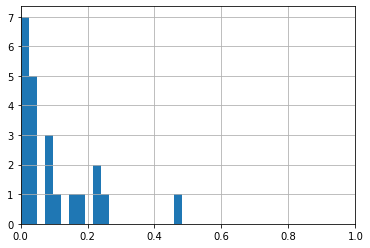

In [207]:
df_citation_stats['poi_ncommon_refs'].hist(bins=20)
plt.xlim([0,1])

(0, 1)

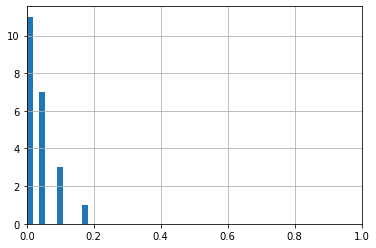

In [209]:
df_citation_stats['poi_ncommon_citers'].hist()
plt.xlim([0,1])